# Hadamard (Element-wise) Multiplication and Its Role in GRU Networks (TensorFlow Edition)

Objectives:
1. Understand the Hadamard (element-wise) product vs standard matrix multiplication.
2. Practice with simple numerical examples and visualizations.
3. Examine how GRU gates rely on Hadamard products for selective information flow.
4. Build a GRU-based time-series forecasting model (synthetic but realistic multivariate data) using TensorFlow / Keras.
5. Evaluate performance, visualize forecasts, and inspect gate behavior.

We re-implement the prior PyTorch-based lab fully in TensorFlow as requested.

---
Run the notebook top-to-bottom.

## 1. Hadamard (Element-wise) Multiplication
Given two conformable matrices (same shape) $A, B \in \mathbb{R}^{m \times n}$, the Hadamard product is:
$$(A \odot B)_{ij} = A_{ij} B_{ij}.$$

Contrast that with standard matrix multiplication $(A B)$ requiring inner dimension compatibility and producing sums over products of rows/columns.

In neural network gating (e.g. GRUs, LSTMs), the Hadamard product lets a gate vector (values typically in [0,1]) *scale each hidden dimension independently*—something matrix multiplication cannot substitute for without altering dimensional semantics.

In [18]:
import numpy as np

A = np.array([[1,2,3],[4,5,6]])
B = np.array([[10,20,30],[1,2,3]])
hadamard = A * B          # Element-wise
matmul = A @ B.T          # Standard matrix multiplication
A, B, hadamard, matmul

(array([[1, 2, 3],
        [4, 5, 6]]),
 array([[10, 20, 30],
        [ 1,  2,  3]]),
 array([[10, 40, 90],
        [ 4, 10, 18]]),
 array([[140,  14],
        [320,  32]]))

Visualization of per-cell scaling via Hadamard product.

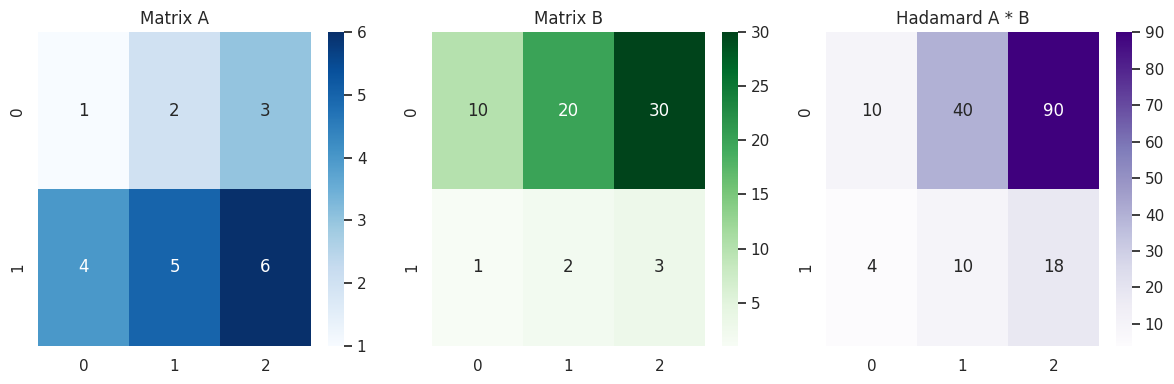

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context='notebook', style='whitegrid')

fig, axes = plt.subplots(1,3, figsize=(12,4))
sns.heatmap(A, annot=True, fmt='d', cmap='Blues', ax=axes[0]).set_title('Matrix A')
sns.heatmap(B, annot=True, fmt='d', cmap='Greens', ax=axes[1]).set_title('Matrix B')
sns.heatmap(hadamard, annot=True, fmt='d', cmap='Purples', ax=axes[2]).set_title('Hadamard A * B')
plt.tight_layout()

## 2. GRU Gates and Hadamard Products
A (reset-after=False) GRU cell (simplified) uses:
\begin{align}
z_t &= \sigma(x_t W_z + h_{t-1} U_z + b_z) \\ 
r_t &= \sigma(x_t W_r + h_{t-1} U_r + b_r) \\ 
\tilde{h}_t &= \tanh(x_t W_h + (r_t \odot h_{t-1}) U_h + b_h) \\ 
h_t &= (1 - z_t) \odot h_{t-1} + z_t \odot \tilde{h}_t
\end{align}

Each bold Hadamard shows element-wise gating. Without it, all hidden dimensions would mix or update identically rather than independently.

Below: manual single-step GRU example (random weights) to illustrate gating shapes.

In [20]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

np.random.seed(42)
input_dim = 4
hidden_dim = 5

W_z = np.random.randn(input_dim, hidden_dim)
U_z = np.random.randn(hidden_dim, hidden_dim)
b_z = np.random.randn(hidden_dim)

W_r = np.random.randn(input_dim, hidden_dim)
U_r = np.random.randn(hidden_dim, hidden_dim)
b_r = np.random.randn(hidden_dim)

W_h = np.random.randn(input_dim, hidden_dim)
U_h = np.random.randn(hidden_dim, hidden_dim)
b_h = np.random.randn(hidden_dim)

x_t = np.random.randn(input_dim)
h_prev = np.random.randn(hidden_dim)

z_t = sigmoid(x_t @ W_z + h_prev @ U_z + b_z)
r_t = sigmoid(x_t @ W_r + h_prev @ U_r + b_r)
h_tilde = np.tanh(x_t @ W_h + (r_t * h_prev) @ U_h + b_h)
h_t = (1 - z_t) * h_prev + z_t * h_tilde

print('z_t (update):', z_t)
print('r_t (reset):', r_t)
print('h~ (candidate):', h_tilde)
print('h_t (new state):', h_t)

z_t (update): [0.06165554 0.98579858 0.58154724 0.3589542  0.93397452]
r_t (reset): [0.15931683 0.58737048 0.99277115 0.67609808 0.38064326]
h~ (candidate): [-0.88937528 -0.77083814 -0.99095418 -0.05253341 -0.89375924]
h_t (new state): [ 0.22016802 -0.77003595  0.20445183  0.28489152 -0.91340474]


## 3. Time-Series Forecasting with TensorFlow GRU
We create a realistic synthetic multivariate time series (e.g., energy load) with:
- Trend
- Short and long seasonalities
- Temperature covariate
- Day-of-week one-hot
- Noise

Goal: Predict next timestep load given past window of all features.

Process steps:
1. Generate data
2. Train / validation / test split (chronological)
3. Scale features
4. Create sliding windows
5. Build & train GRU model
6. Evaluate vs naive baseline
7. Visualize predictions
8. Gate introspection (manually using trained weights)

We explicitly set `reset_after=False` in the GRU for simpler gate reconstruction.

In [21]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style='whitegrid')
np.random.seed(0)
tf.random.set_seed(0)

n = 2000
t = np.arange(n)

trend = 0.0008 * t
season_daily = 0.7 * np.sin(2*np.pi*t/24)
season_weekly = 0.4 * np.sin(2*np.pi*t/(24*7))
temp = 15 + 10 * np.sin(2*np.pi*(t+5)/(24*7)) + 2 * np.sin(2*np.pi*t/24) + np.random.normal(0,1.5,n)
day_of_week = (t // 24) % 7
dow_one_hot = np.zeros((n,7))
dow_one_hot[np.arange(n), day_of_week.astype(int)] = 1
noise = np.random.normal(0,0.3,n)
load = 5 + trend + season_daily + season_weekly + 0.05*temp + noise

data = pd.DataFrame({
    'time': t,
    'load': load,
    'temp': temp,
    'trend': trend,
    'season_daily': season_daily,
    'season_weekly': season_weekly,
})
for i in range(7):
    data[f'dow_{i}'] = dow_one_hot[:, i]

data.head()

,time,load,temp,trend,season_daily,season_weekly,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6
0,0,5.515383,19.505195,0.0000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,5.600493,18.343083,0.0008,0.181173,0.014956,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,6.398147,20.056297,0.0016,0.350000,0.029892,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,6.390803,22.723105,0.0024,0.494975,0.044786,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,6.786600,22.836178,0.0032,0.606218,0.059617,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### Visualize Components

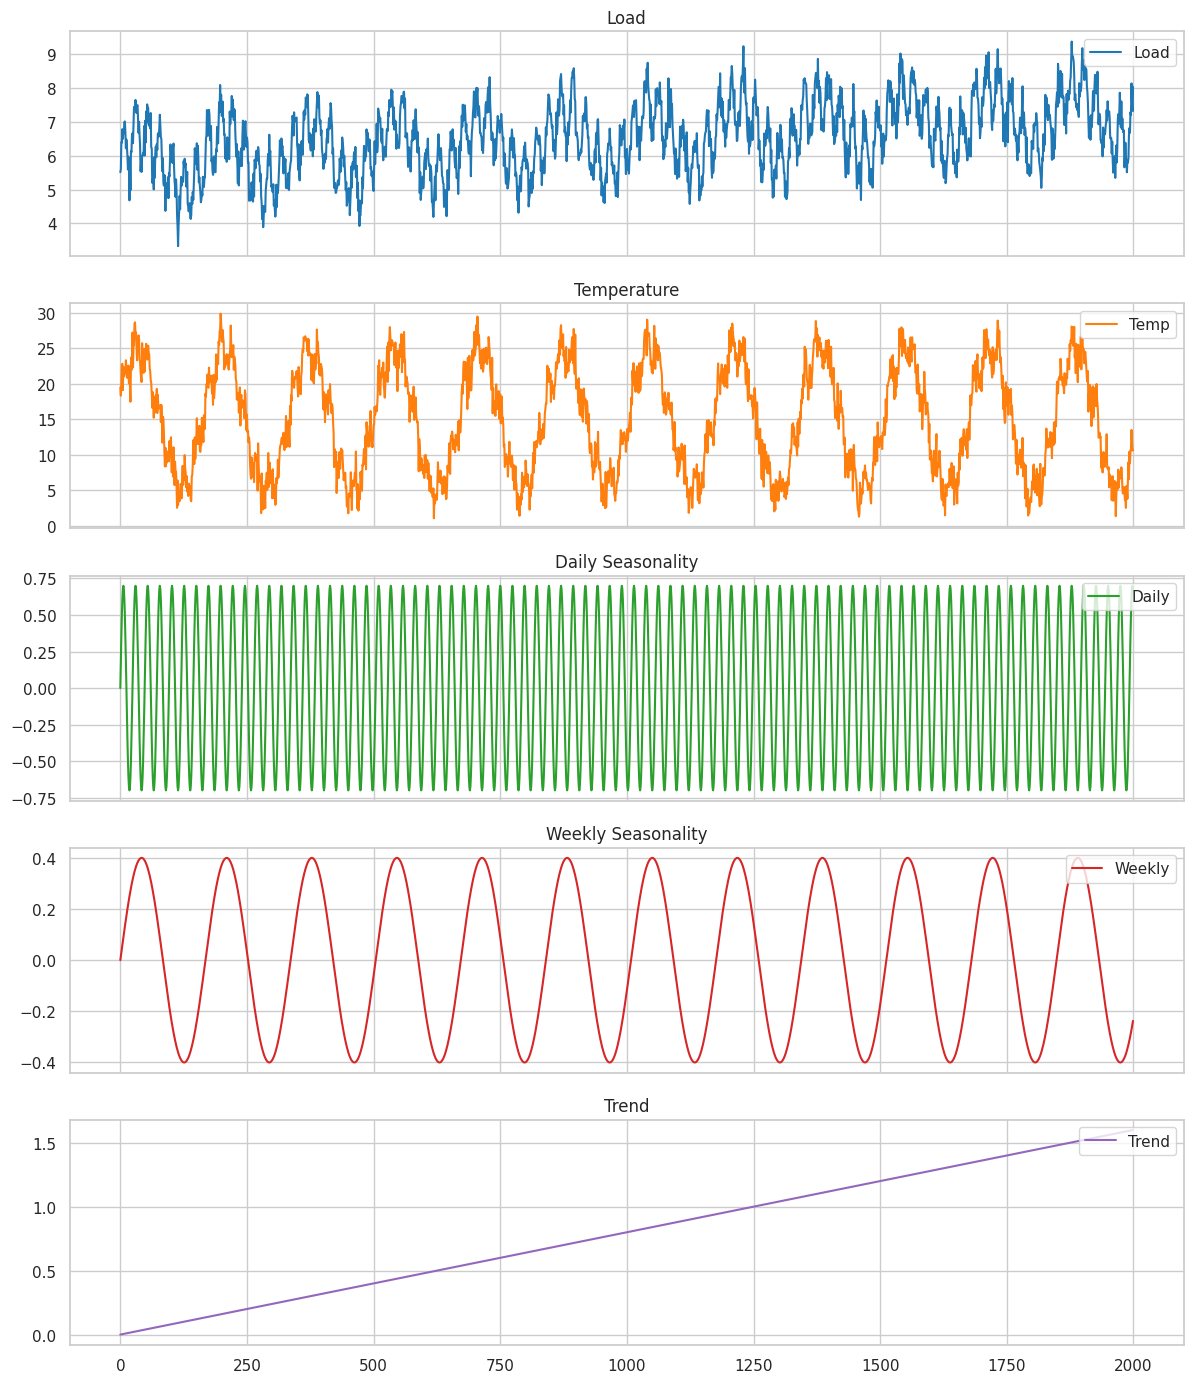

In [22]:
fig, axes = plt.subplots(5,1, figsize=(12,14), sharex=True)
axes[0].plot(data['time'], data['load'], label='Load', color='tab:blue')
axes[0].set_title('Load')
axes[1].plot(data['time'], data['temp'], label='Temp', color='tab:orange')
axes[1].set_title('Temperature')
axes[2].plot(data['time'], data['season_daily'], label='Daily', color='tab:green')
axes[2].set_title('Daily Seasonality')
axes[3].plot(data['time'], data['season_weekly'], label='Weekly', color='tab:red')
axes[3].set_title('Weekly Seasonality')
axes[4].plot(data['time'], data['trend'], label='Trend', color='tab:purple')
axes[4].set_title('Trend')
for ax in axes:
    ax.legend(loc='upper right')
plt.tight_layout()

### Split & Scale
Chronological split: 70% train, 15% val, 15% test.

In [23]:
features = [c for c in data.columns if c != 'time']
target_col = 'load'
values = data[features].values.astype(np.float32)
n_train = int(0.7*n)
n_val = int(0.15*n)
n_test = n - n_train - n_val
train_vals = values[:n_train]
val_vals = values[n_train:n_train+n_val]
test_vals = values[n_train+n_val:]

scaler = MinMaxScaler()
scaler.fit(train_vals)
train_scaled = scaler.transform(train_vals)
val_scaled = scaler.transform(val_vals)
test_scaled = scaler.transform(test_vals)

train_scaled.shape, val_scaled.shape, test_scaled.shape

((1400, 12), (300, 12), (300, 12))

### Sliding Window Dataset
Window size defines historical context. Input: past `window_size` rows (all features). Output: next timestep's load (single scalar).

In [24]:
window_size = 48
target_index = features.index(target_col)

def build_windows(array, window, target_index):
    X, y = [], []
    for i in range(len(array) - window):
        X.append(array[i:i+window])
        y.append(array[i+window, target_index])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

X_train, y_train = build_windows(train_scaled, window_size, target_index)
X_val, y_val = build_windows(val_scaled, window_size, target_index)
X_test, y_test = build_windows(test_scaled, window_size, target_index)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((1352, 48, 12), (1352,), (252, 48, 12), (252,), (252, 48, 12), (252,))

### TensorFlow Datasets
We create shuffled batched datasets for training and plain batched for validation/testing.

In [25]:
batch_size = 64

train_ds = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
            .shuffle(2048, seed=0, reshuffle_each_iteration=True)
            .batch(batch_size)
            .prefetch(tf.data.AUTOTUNE))
val_ds = (tf.data.Dataset.from_tensor_slices((X_val, y_val))
          .batch(batch_size)
          .prefetch(tf.data.AUTOTUNE))
test_ds = (tf.data.Dataset.from_tensor_slices((X_test, y_test))
           .batch(batch_size)
           .prefetch(tf.data.AUTOTUNE))

train_ds, val_ds, test_ds

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 48, 12), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 48, 12), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 48, 12), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>)

### GRU Model Definition
We use Keras `GRU` layer with `reset_after=False` to keep gating math simpler for later manual introspection.

Model: GRU -> Dense(1). Loss: MSE, optimizer: Adam.

In [26]:
from tensorflow.keras import layers, models, callbacks, optimizers

input_dim = X_train.shape[-1]

def build_model(hidden_units=64, dropout=0.0):
    inp = layers.Input(shape=(window_size, input_dim))
    x = layers.GRU(hidden_units, reset_after=False, return_sequences=False)(inp)
    if dropout>0:
        x = layers.Dropout(dropout)(x)
    out = layers.Dense(1)(x)
    model = models.Model(inp, out)
    model.compile(optimizer=optimizers.Adam(1e-3), loss='mse')
    return model

model = build_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 48, 12)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        14,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,849 (58.00 KB)

 Trainable params: 14,849 (58.00 KB)

 Non-trainable params: 0 (0.00 B)

### Training with Early Stopping
We track training & validation loss, restoring best weights (lowest validation MSE).

In [27]:
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(train_ds, validation_data=val_ds, epochs=40, callbacks=[es], verbose=1)
best_val = min(history.history['val_loss'])
best_val

Epoch 1/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0671 - val_loss: 0.0198
Epoch 2/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0120 - val_loss: 0.0189
Epoch 3/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0053 - val_loss: 0.0056
Epoch 4/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 5/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 6/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0028 - val_loss: 0.0031
Epoch 7/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0027 - val_loss: 0.0031
Epoch 8/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - val_loss: 0.0030
Epoch 9/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - val_loss: 0.0032
Epoch 10/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - val_loss: 0.0031
Epoch 11/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0026 - val_loss: 0.0030
Epoch 12/40
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0027 - val_l

0.002980853198096156

### Training Curves

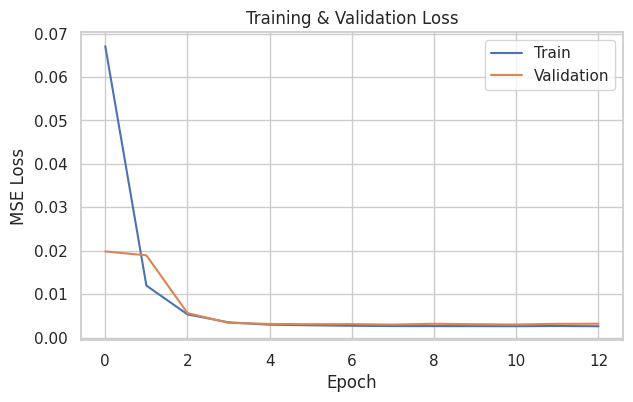

In [28]:
plt.figure(figsize=(7,4))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training & Validation Loss')
plt.legend();

### Evaluation & Metrics
Compute predictions, invert scaling for target, then compute MAE, RMSE, MAPE. Compare to naive persistence baseline (last value in window).

In [29]:
import math

pred_scaled = model.predict(test_ds)
y_scaled = y_test.reshape(-1,1)

def inverse_scale_target(scaled_target_col):
    # Build placeholder with zeros except target column
    full = np.zeros((scaled_target_col.shape[0], len(features)), dtype=np.float32)
    full[:, target_index] = scaled_target_col[:,0]
    inv = scaler.inverse_transform(full)
    return inv[:, target_index]

pred_inv = inverse_scale_target(pred_scaled)
y_inv = inverse_scale_target(y_scaled)

# Naive baseline (last value of input window)
naive_scaled = X_test[:, -1, target_index].reshape(-1,1)
naive_inv = inverse_scale_target(naive_scaled)

def metrics(y_true, y_pred):
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = math.sqrt(np.mean((y_true - y_pred)**2))
    mape = np.mean(np.abs((y_true - y_pred)/y_true)) * 100
    return mae, rmse, mape

mae, rmse, mape = metrics(y_inv, pred_inv)
n_mae, n_rmse, n_mape = metrics(y_inv, naive_inv)
print(f'GRU   -> MAE: {mae:.4f} | RMSE: {rmse:.4f} | MAPE: {mape:.2f}%')
print(f'Naive -> MAE: {n_mae:.4f} | RMSE: {n_rmse:.4f} | MAPE: {n_mape:.2f}%')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
GRU   -> MAE: 0.2599 | RMSE: 0.3202 | MAPE: 3.71%
Naive -> MAE: 0.3783 | RMSE: 0.4798 | MAPE: 5.39%


### Prediction Plot
Visual comparison on the last segment of test predictions vs actual and naive baseline.

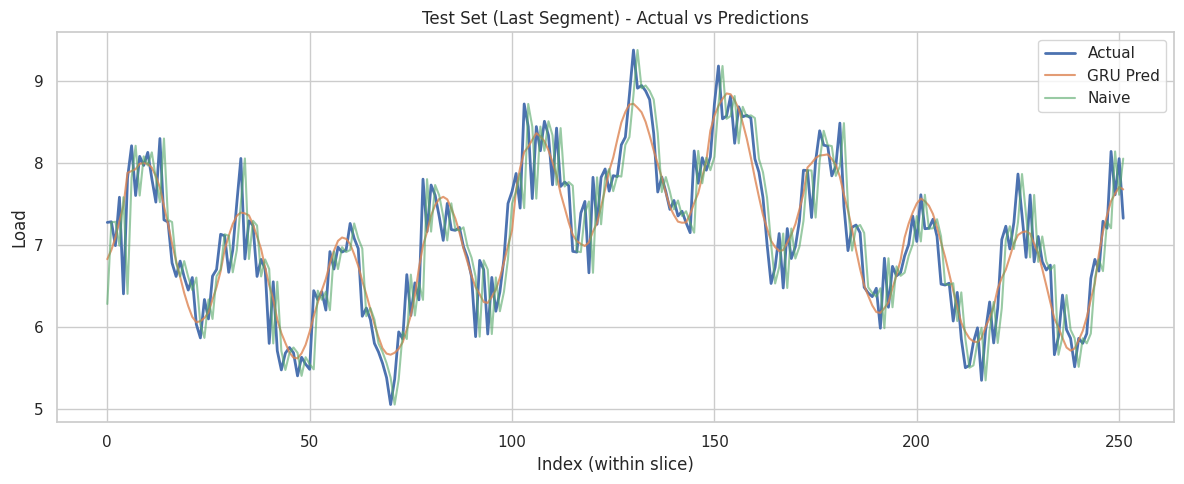

In [30]:
plot_len = 300
plt.figure(figsize=(12,5))
plt.plot(y_inv[-plot_len:], label='Actual', linewidth=2)
plt.plot(pred_inv[-plot_len:], label='GRU Pred', alpha=0.8)
plt.plot(naive_inv[-plot_len:], label='Naive', alpha=0.6)
plt.title('Test Set (Last Segment) - Actual vs Predictions')
plt.xlabel('Index (within slice)')
plt.ylabel('Load')
plt.legend()
plt.tight_layout()

### Residual Distribution
Inspect error distribution for bias/skew. Ideally centered near zero, roughly symmetric.

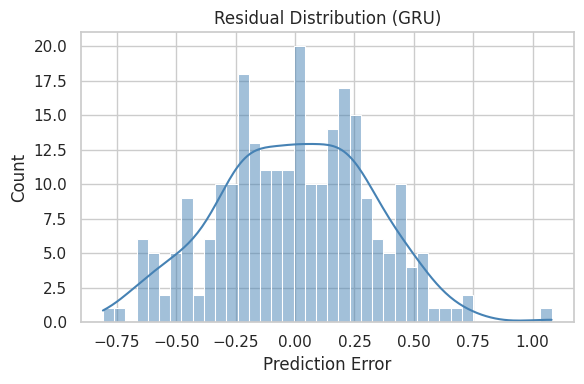

In [31]:
residuals = pred_inv - y_inv
plt.figure(figsize=(6,4))
sns.histplot(residuals, bins=40, kde=True, color='steelblue')
plt.title('Residual Distribution (GRU)')
plt.xlabel('Prediction Error')
plt.tight_layout()

## 4. Gate Introspection (Manual Reconstruction)
Keras does not directly expose gate activations per timestep. We reconstruct them manually for a small batch using the trained weights.

We configured `reset_after=False`, so equations align with the simpler form previously stated. Keras `GRU` stores weights:
- `kernel`: shape (input_dim, 3*units)
- `recurrent_kernel`: shape (units, 3*units)
- `bias`: shape (3*units,) because reset_after=False

The internal gate order in Keras is `[update (z), reset (r), new (h_tilde)]` by default. We will slice accordingly.

In [32]:
gru_layer = None
for lyr in model.layers:
    if isinstance(lyr, layers.GRU):
        gru_layer = lyr
        break
assert gru_layer is not None, 'GRU layer not found'

kernel, recurrent_kernel, bias = gru_layer.get_weights()
units = gru_layer.units

# Slice weights: z, r, h  (order confirmed from Keras source)
W_z, W_r, W_h = np.hsplit(kernel, 3)
U_z, U_r, U_h = np.hsplit(recurrent_kernel, 3)
b_z, b_r, b_h = np.split(bias, 3)

def gru_gates_sequence(x_seq, h0=None):
    # x_seq: (T, F)
    if h0 is None:
        h_t = np.zeros(units, dtype=np.float32)
    else:
        h_t = h0.copy()
    z_list, r_list, htilde_list, h_list = [], [], [], []
    for x_t in x_seq:
        z_t = 1/(1+np.exp(-(x_t @ W_z + h_t @ U_z + b_z)))
        r_t = 1/(1+np.exp(-(x_t @ W_r + h_t @ U_r + b_r)))
        h_candidate = np.tanh(x_t @ W_h + (r_t * h_t) @ U_h + b_h)
        h_t = (1 - z_t) * h_t + z_t * h_candidate
        z_list.append(z_t)
        r_list.append(r_t)
        htilde_list.append(h_candidate)
        h_list.append(h_t)
    return np.array(z_list), np.array(r_list), np.array(htilde_list), np.array(h_list)

# Choose a small batch from test set
sample_batch = X_test[:8]  # (B, T, F)
z_all, r_all = [], []
for seq in sample_batch:
    z_seq, r_seq, htilde_seq, h_seq = gru_gates_sequence(seq)
    z_all.append(z_seq)
    r_all.append(r_seq)
z_all = np.array(z_all)  # (B, T, units)
r_all = np.array(r_all)
z_all.shape, r_all.shape

((8, 48, 64), (8, 48, 64))

We aggregate gate activations across batch and time to inspect their distributions.

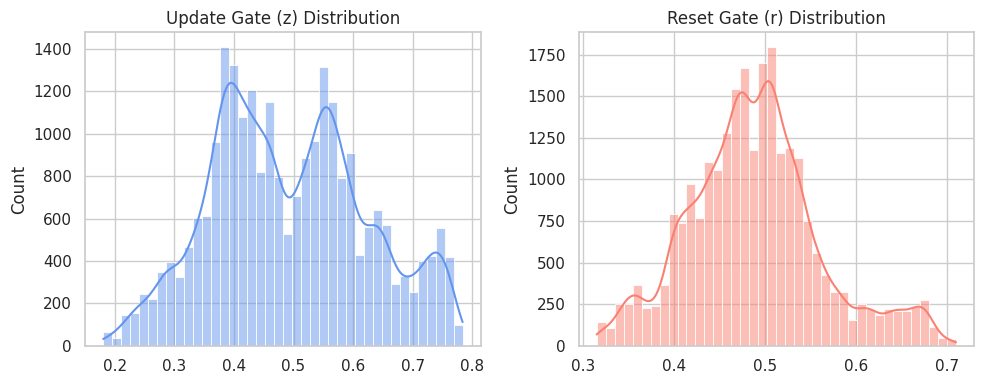

In [33]:
z_vals = z_all.flatten()
r_vals = r_all.flatten()
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(z_vals, bins=40, kde=True, color='cornflowerblue')
plt.title('Update Gate (z) Distribution')
plt.subplot(1,2,2)
sns.histplot(r_vals, bins=40, kde=True, color='salmon')
plt.title('Reset Gate (r) Distribution')
plt.tight_layout()

Interpretation:
- z near 0 => keep prior state; near 1 => replace with candidate.
- r near 0 => limit past state influence in candidate; near 1 => allow full influence.

Each dimension independently decides—thanks to Hadamard gating.